In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import folium

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor 

from scipy import stats

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-v0_8')

In [90]:
df = pd.read_csv('detailed_ev_charging_stations.csv')

In [92]:
#Removing "Random Rd" and numbered cities entries to keep only valid addresses
df_filtered = df[~df['Address'].str.contains('Random Rd|City \d+', na=False, regex=True)]

In [94]:
#Basic information
print("Dataset Info (Valid Entries Only:")
print(df_filtered.info())

Dataset Info (Valid Entries Only:
<class 'pandas.core.frame.DataFrame'>
Index: 4500 entries, 1 to 4999
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Station ID                   4500 non-null   object 
 1   Latitude                     4500 non-null   float64
 2   Longitude                    4500 non-null   float64
 3   Address                      4500 non-null   object 
 4   Charger Type                 4500 non-null   object 
 5   Cost (USD/kWh)               4500 non-null   float64
 6   Availability                 4500 non-null   object 
 7   Distance to City (km)        4500 non-null   float64
 8   Usage Stats (avg users/day)  4500 non-null   int64  
 9   Station Operator             4500 non-null   object 
 10  Charging Capacity (kW)       4500 non-null   int64  
 11  Connector Types              4500 non-null   object 
 12  Installation Year            4500 non-null   in

In [96]:
#Basic numerical statistics
print("\nNumerical Statistics (Valid Entries only):")
print(df_filtered.describe())


Numerical Statistics (Valid Entries only):
          Latitude    Longitude  Cost (USD/kWh)  Distance to City (km)  \
count  4500.000000  4500.000000     4500.000000            4500.000000   
mean     21.785652    10.039214        0.300776              10.183644   
std      28.439351    92.327869        0.115911               5.609258   
min     -33.899305  -122.499694        0.100000               0.500000   
25%      13.851484   -87.673557        0.200000               5.437500   
50%      34.078109    18.507158        0.300000              10.155000   
75%      41.810389   100.465345        0.400000              14.890000   
max      55.899682   151.399431        0.500000              20.000000   

       Usage Stats (avg users/day)  Charging Capacity (kW)  Installation Year  \
count                  4500.000000             4500.000000        4500.000000   
mean                     55.352000              143.081778        2016.556000   
std                      26.505635            

In [98]:
#Check for missing values
print("\nMissing Values (Valid Entries Only):")
print(df_filtered.isnull().sum())


Missing Values (Valid Entries Only):
Station ID                     0
Latitude                       0
Longitude                      0
Address                        0
Charger Type                   0
Cost (USD/kWh)                 0
Availability                   0
Distance to City (km)          0
Usage Stats (avg users/day)    0
Station Operator               0
Charging Capacity (kW)         0
Connector Types                0
Installation Year              0
Renewable Energy Source        0
Reviews (Rating)               0
Parking Spots                  0
Maintenance Frequency          0
dtype: int64


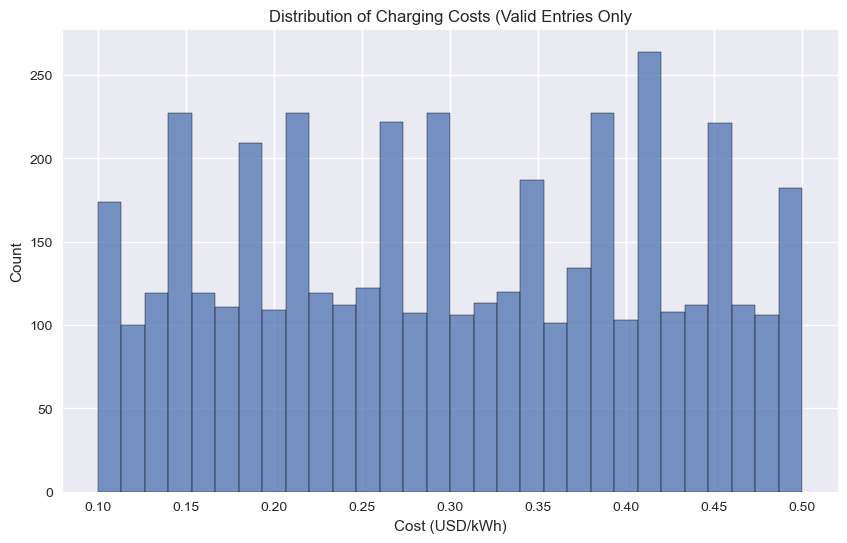

In [100]:
# Distribution of charging costs
plt.figure(figsize=(10,6))
sns.histplot(data=df_filtered, x='Cost (USD/kWh)', bins=30)
plt.title('Distribution of Charging Costs (Valid Entries Only')
plt.xlabel('Cost (USD/kWh)')
plt.show()

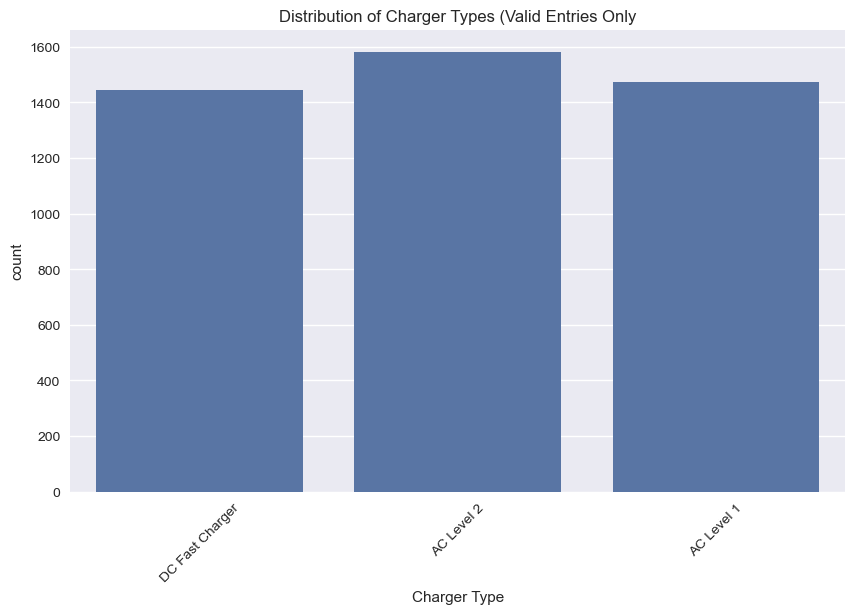

In [102]:
#Distribution of charger types
plt.figure(figsize=(10,6))
sns.countplot(data=df_filtered, x='Charger Type')
plt.title('Distribution of Charger Types (Valid Entries Only')
plt.xticks(rotation=45)
plt.show()

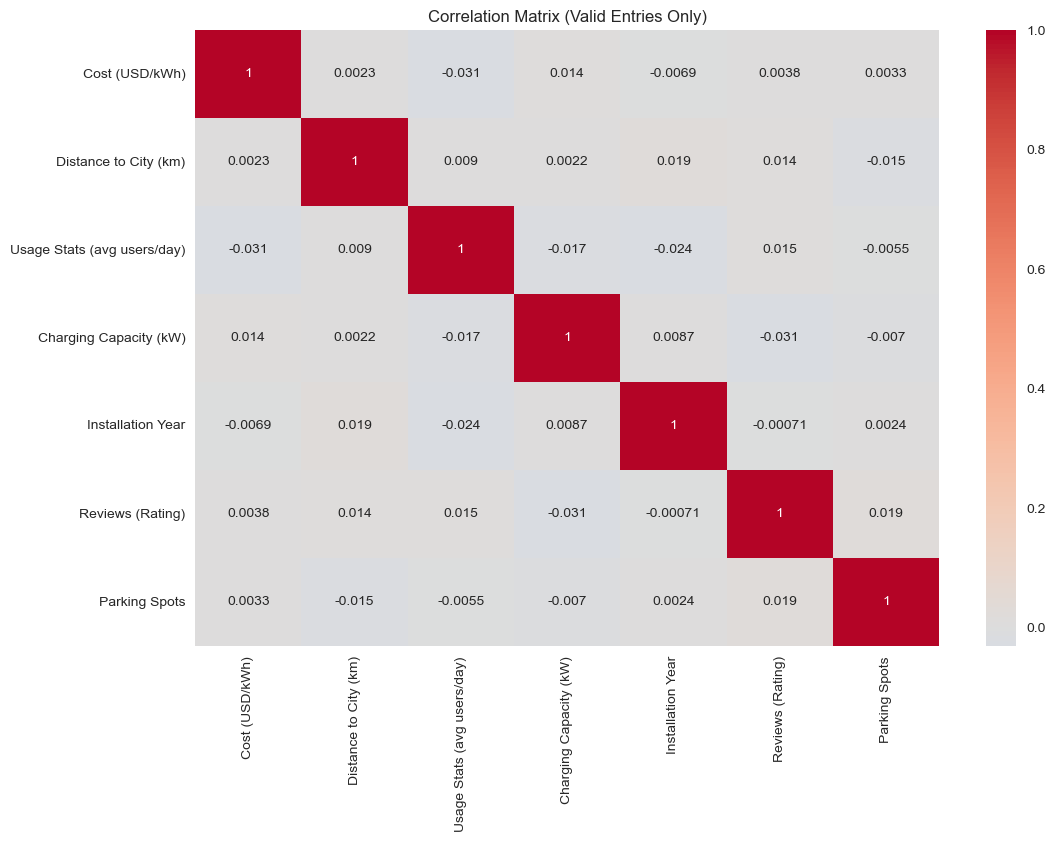

In [104]:
#Correlations matrix for numerical data
numerical_cols = ['Cost (USD/kWh)', 'Distance to City (km)', 'Usage Stats (avg users/day)', 'Charging Capacity (kW)', 'Installation Year', 'Reviews (Rating)', 'Parking Spots']
correlation_matrix = df_filtered[numerical_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix (Valid Entries Only)')
plt.show()

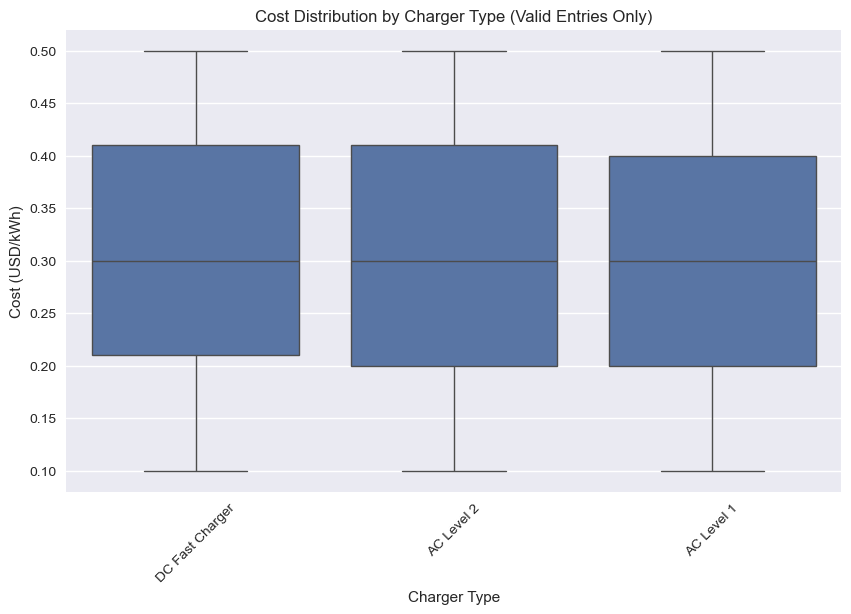

In [106]:
#Box plot for costs by charger type
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtered, x='Charger Type', y='Cost (USD/kWh)')
plt.title('Cost Distribution by Charger Type (Valid Entries Only)')
plt.xticks(rotation=45)
plt.show()

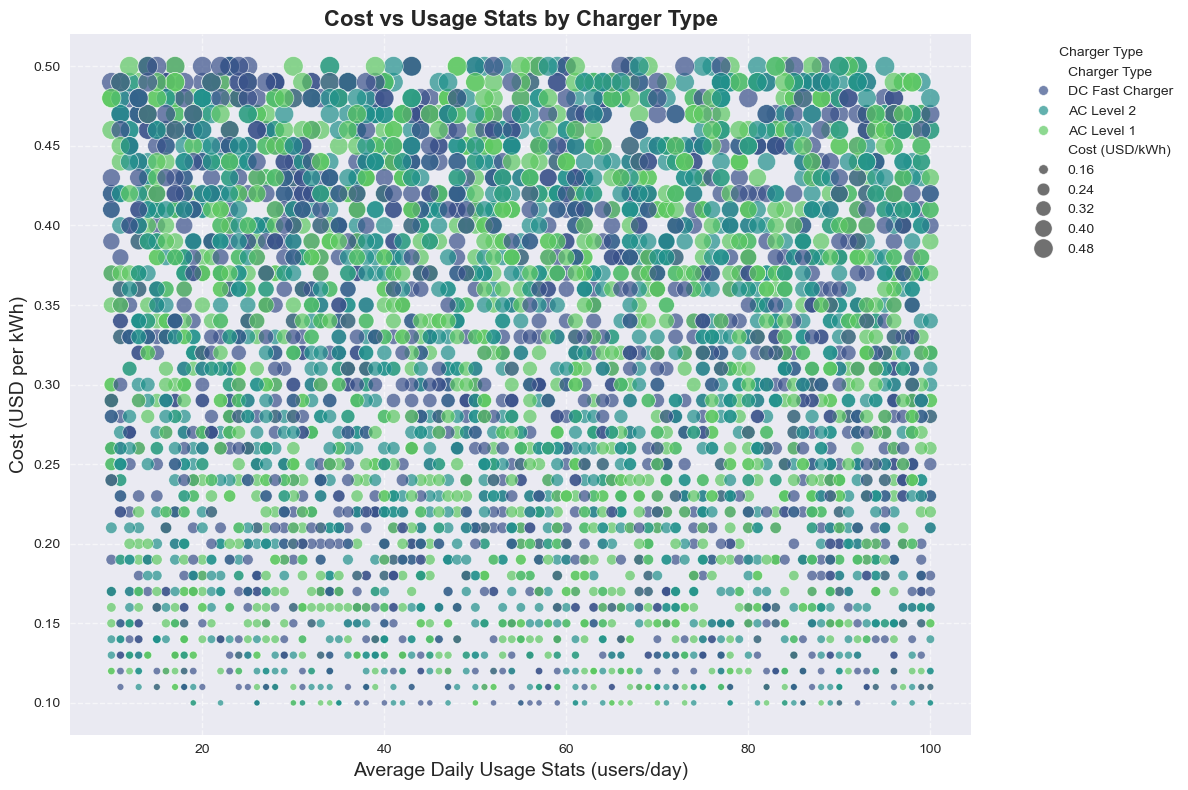

In [108]:
# Scatter plot of cost versus usage with enhancements
plt.figure(figsize=(12, 8))  # Larger figure size for readability
sns.scatterplot(data=df_filtered, 
                x='Usage Stats (avg users/day)', 
                y='Cost (USD/kWh)', 
                alpha=0.7,  # Slightly less transparency for clarity
                hue='Charger Type', 
                palette='viridis',  # Use a visually distinct color palette
                size='Cost (USD/kWh)',  # Optional: Size points based on cost
                sizes=(20, 200))  # Define size range for the points

# Add a grid for better readability
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Set title with larger font
plt.title('Cost vs Usage Stats by Charger Type', fontsize=16, fontweight='bold')

# Add axis labels with larger font
plt.xlabel('Average Daily Usage Stats (users/day)', fontsize=14)
plt.ylabel('Cost (USD per kWh)', fontsize=14)

# Add a legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Charger Type', fontsize=10)

# Tight layout to minimize white space
plt.tight_layout()

# Show the plot
plt.show()  

In [109]:
# Summary statistics by station operator 
print("\nSummary by Station Operator:")
operator_summary = df_filtered.groupby('Station Operator').agg({
    'Cost (USD/kWh)': ['mean', 'min', 'max', 'count'],
    'Reviews (Rating)': 'mean',
    'Usage Stats (avg users/day)': 'mean'
}).round(2)
print(operator_summary)


Summary by Station Operator:
                 Cost (USD/kWh)                 Reviews (Rating)  \
                           mean  min  max count             mean   
Station Operator                                                   
ChargePoint                0.30  0.1  0.5   903             3.98   
EVgo                       0.30  0.1  0.5   901             4.00   
Greenlots                  0.31  0.1  0.5   889             3.98   
Ionity                     0.30  0.1  0.5   879             3.98   
Tesla                      0.30  0.1  0.5   928             4.01   

                 Usage Stats (avg users/day)  
                                        mean  
Station Operator                              
ChargePoint                            55.43  
EVgo                                   56.54  
Greenlots                              56.42  
Ionity                                 54.24  
Tesla                                  54.16  


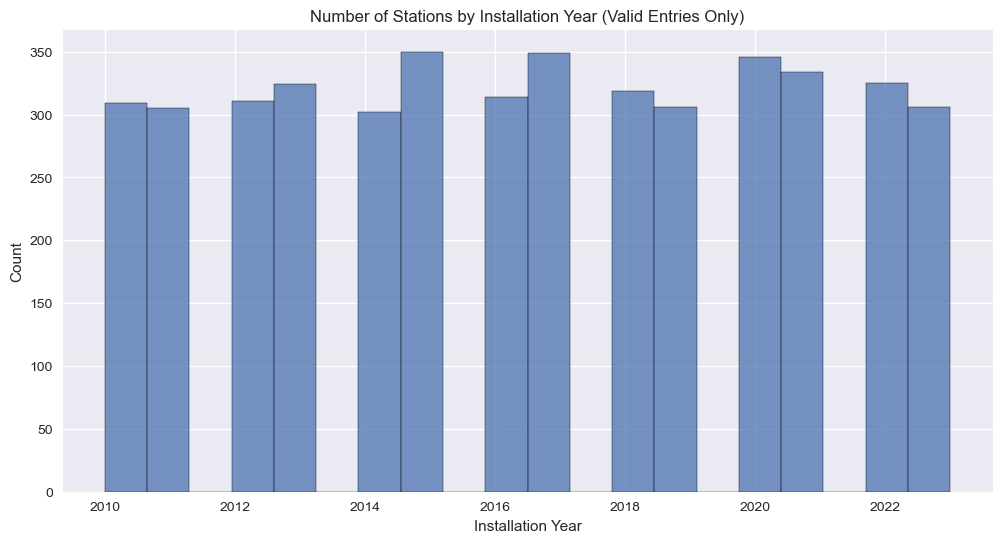

In [112]:
#Installation trends over time
plt.figure(figsize=(12, 6))
sns.histplot(data=df_filtered, x='Installation Year', bins=20)
plt.title('Number of Stations by Installation Year (Valid Entries Only)')
plt.show()

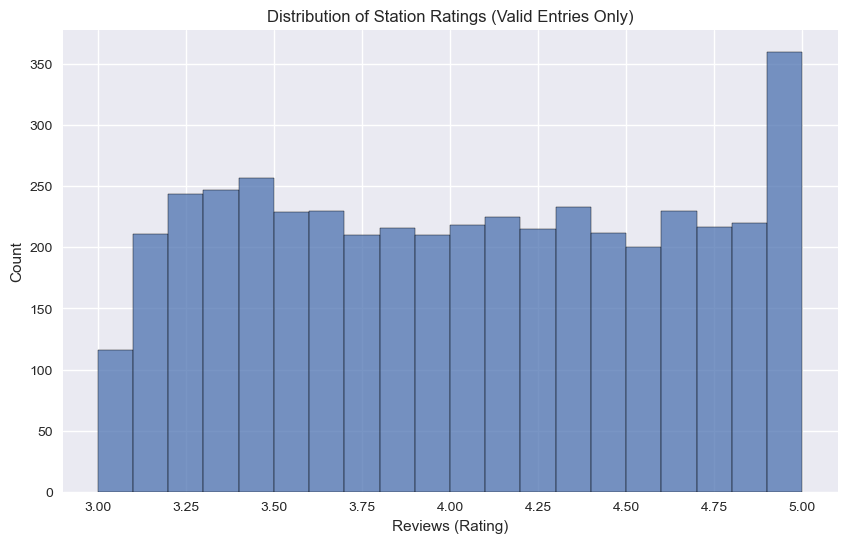

In [118]:
#Average ratings distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df_filtered, x='Reviews (Rating)', bins=20)
plt.title('Distribution of Station Ratings (Valid Entries Only)')
plt.show()

In [120]:
# Additional analysis for the filtered dataset
print("\nSummary Statistics for Valid Entries:")
print(f"Total number of valid stations: {len(df_filtered)}")
print("\nAverage cost by city:")
print(df_filtered.groupby(df_filtered['Address'].apply(lambda x: x.split(',')[1].strip()))['Cost (USD/kWh)'].mean().round(2).sort_values(ascending=False).head())

print("\nMost common station operators:")
print(df_filtered['Station Operator'].value_counts().head())

print("\nAverage rating by charger type:")
print(df_filtered.groupby('Charger Type')['Reviews (Rating)'].mean().round(2))

# City usage for valid entries
print("\nUsage statistics by city:")
city_usage = df_filtered.groupby(df_filtered['Address'].apply(lambda x: x.split(',')[1].strip()))['Usage Stats (avg users/day)'].agg(['mean', 'max']).round(2)
print(city_usage.sort_values('mean', ascending=False).head())


Summary Statistics for Valid Entries:
Total number of valid stations: 4500

Average cost by city:
Address
Bangkok    0.31
Beijing    0.31
Moscow     0.31
Seoul      0.31
Sydney     0.31
Name: Cost (USD/kWh), dtype: float64

Most common station operators:
Station Operator
Tesla          928
ChargePoint    903
EVgo           901
Greenlots      889
Ionity         879
Name: count, dtype: int64

Average rating by charger type:
Charger Type
AC Level 1         3.97
AC Level 2         3.98
DC Fast Charger    4.02
Name: Reviews (Rating), dtype: float64

Usage statistics by city:
                mean  max
Address                  
San Francisco  57.85   99
Mumbai         57.05  100
Toronto        56.72  100
Beijing        56.69  100
Moscow         56.27  100


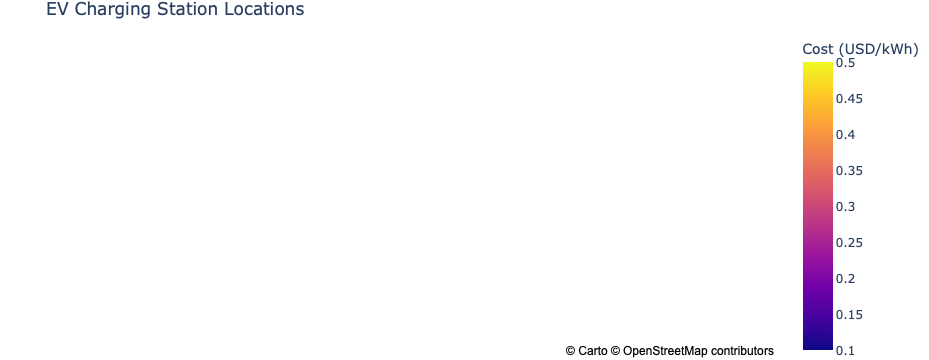

In [122]:
# Create the map visualization with filtered data
fig = px.scatter_mapbox(df_filtered, 
                       lat='Latitude', 
                       lon='Longitude', 
                       color='Cost (USD/kWh)',
                       size='Usage Stats (avg users/day)',
                       hover_data=['Charger Type', 'Station Operator', 'Address'],
                       zoom=2,
                       title='EV Charging Station Locations')

fig.update_layout(
    mapbox_style='carto-positron',
    mapbox=dict(
        center=dict(lat=20, lon=0),
    ),
    margin={"r":0,"t":30,"l":0,"b":0}
)

fig.show()